<h1>Preprocessing Site Names<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li>
        <span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1">
        <span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span>
        </li>
        <li>
            <span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2">
            <span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span>
            <ul class="toc-item">
                <li>
                <span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span>
                <ul class="toc-item">
                <li>
                <span><a href="#Match-orgunitlevel4-to-Geob-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-Geob-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to Geob Adm 3</a></span>
                </li>
                <li>
                <span><a href="#Match-orgunitlevel3-to-Geob-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-Geob-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to Geob Adm 2</a></span>
                </li>
                <li>
                <span><a href="#Match-orgunitlevel2-to-Geob-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-Geob-Adm-1-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Match orgunitlevel2 to Geob Adm 1</a></span>
                </li>
                </ul>
            </li>
        </ul>
    </li>
</div>

Version: April 11, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)

# Packages and functions

In [1]:
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

# local imports
import preprocessing_utils as ppu
import search_utils as ssu

In [2]:
from ctypes.util import find_library
find_library('c')

'/usr/lib/libc.dylib'

# Prepare and match admin boundary data

In [3]:
iso3 = "SLE"
country = "Sierra Leone"
input_dir = "/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/data"
input_filename = "sierraleone2023-04-17.csv"
output_dir = join(input_dir, "output", iso3)
num_admin_levels = 3
words_to_remove = [" Chiefdom", " City Council", " Council", "District Council", " Municipal Council", " District", " Zone"]

In [4]:
geob_arr = ppu.get_geoboundaries(num_admin_levels, iso3)

In [5]:
master_table = ppu.process_masterDF(input_dir, input_filename)

Len of original data: 181378
Len of clean data: 1344

Unique Level 2: 16
Unique Level 3: 22
Unique Level 4: 208
Unique Level 5: 1344


In [6]:
geobList_arr = []
for idx, geob in enumerate(geob_arr):
    admIdx = idx+1
    print(f"Unique Geoboundaries Adm {admIdx}: {len(geob)}")
    try:
        geob_list = list(geob.shapeName)
    except:
        #print(geob)
        geob_list = list(geob.admin2Name)
    geob_list.sort()
    geobList_arr.append(geob_list)

Unique Geoboundaries Adm 1: 4
Unique Geoboundaries Adm 2: 14
Unique Geoboundaries Adm 3: 165


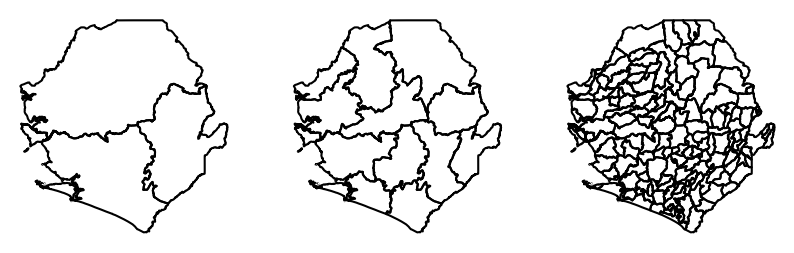

In [7]:
fig, ax = plt.subplots(1, num_admin_levels, figsize=(10,10))
for idx, geob in enumerate(geob_arr):
    geob.boundary.plot(ax=ax[idx], color='black').set_axis_off()

## Match health list admin names to shapefile admin names
### Match highest Geob Adm to orgunitlevel
Try using fuzzy matching  

In [8]:
if num_admin_levels == 2:
    org_unit_level = 3
elif  num_admin_levels > 2:
    org_unit_level = 4
else:
    org_unit_level = 1


# Do Matching

In [10]:
curr_geob_lvl = num_admin_levels
curr_org_lvl = org_unit_level
master_table_copy = master_table.copy()

for geobIdx in range(num_admin_levels-1, -1, -1): # reverse loop
    print(f"-----Master list level: {curr_org_lvl}, Geoboundaries level: {curr_geob_lvl}-----")

    master_table_copy.loc[:, f"orgunitlevel{curr_org_lvl}_edit"] = master_table_copy[f"orgunitlevel{curr_org_lvl}"]

    try:
        geob_list = ppu.remove_words(geob_arr[geobIdx], "shapeName", words_to_remove)
    except:
        geob_list = ppu.remove_words(geob_arr[geobIdx], "admin2Name", words_to_remove)

    org_lvl_list = ppu.remove_words(master_table_copy, f"orgunitlevel{curr_org_lvl}_edit", words_to_remove)

    # Print names to inspect
    #ppu.inspect_level_names(curr_org_lvl, org_lvl_list, curr_geob_lvl, geobList_arr[geobIdx])

    table_adm_matches = ssu.find_matches(org_lvl_list.tolist(), geob_list.tolist(), 30, curr_org_lvl, curr_geob_lvl)
    matches_pct = (len(table_adm_matches) / len(org_lvl_list))
    print('Matches for Org level {}, Geob level {}: {:.2f}%'.format(curr_org_lvl, curr_geob_lvl, matches_pct*100))

    # Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced
    # matches in the lookup tables
    for idx, row in master_table_copy.iterrows():
        if row[f"orgunitlevel{curr_org_lvl}_edit"] in list(table_adm_matches[f"name_level{curr_org_lvl}"]):
            match = table_adm_matches.loc[table_adm_matches[f"name_level{curr_org_lvl}"] == row[f"orgunitlevel{curr_org_lvl}_edit"], f"name_geob{curr_geob_lvl}"].iloc[0]
            master_table_copy.loc[idx, f'adm{curr_geob_lvl}'] = match

    if f"adm{curr_geob_lvl}" in master_table_copy.columns:
        notFound = master_table_copy[f"adm{curr_geob_lvl}"].isna().sum()
        print(f"Num not found: {notFound}")
    else:
        print("Num not found: 0")

    print("Matches 80% or less:")
    print(table_adm_matches.loc[table_adm_matches.score<=80])

    # iterate down
    curr_geob_lvl -= 1
    curr_org_lvl -= 1
    print("------------------------------------------")


-----Master list level: 4, Geoboundaries level: 3-----
Matches for Org level 4, Geob level 3: 74.52%
Num not found: 243
Matches 80% or less:
              name_level4      name_geob3  score
29   Yakemoh Kpukumu Krim  Yakemu Kpukumu     80
73            Bonthe Town         Bo Town     80
82                  Nyedu            Neya     80
88                  Bureh         Bramaia     80
119          Kunike Sanda   Kunike Barina     80
121               Makarie           Gaura     80
125               Kabelia             Gbo     80
136             Morifindu        Mafindor     80
154             Kamaranka          Kamara     80
166                  Mara          Kamara     80
181              Maconteh     Makeni Town     80
------------------------------------------
-----Master list level: 3, Geoboundaries level: 2-----
Matches for Org level 3, Geob level 2: 68.42%
Num not found: 198
Matches 80% or less:
Empty DataFrame
Columns: [name_level3, name_geob2, score]
Index: []
-------------------

In [13]:
print(master_table_copy.head())

   index orgunitlevel1 orgunitlevel2              orgunitlevel3  \
0      0       Liberia         Sinoe          Tarjuwon District   
1      4       Liberia       Margibi       Mambah-Kaba District   
2      6       Liberia   Montserrado      Commonwealth District   
3      9       Liberia   Montserrado     Somalia Drive District   
4     12       Liberia   Montserrado  Central Monrovia district   

                     orgunitlevel4 organisationunitid  \
0               Gbason Town Clinic        DAmhVvbzEl6   
1             14 Military Hospital        oUPdjvJABX7   
2  A Place of Rescue Health Clinic        SW1ahVurf5B   
3            A.B.C. Medical Clinic        lp4XqxZqzKw   
4              ACFI Medical Clinic        sxAyKLOcJGW   

              organisationunitname organisationunitcode  \
0               Gbason Town Clinic               LR5GZ3   
1             14 Military Hospital               LR0GW8   
2  A Place of Rescue Health Clinic               LRUPY8   
3            A.B.C

In [14]:
master_table_copy.to_csv(f"{input_dir}/preprocess_{iso3}_matches.csv")